# Installation and import of the library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install vtk
!pip install trimesh
!pip install potpourri3d
! pip install --quiet "pytorch-lightning>=1.4"  "torchmetrics>=0.7"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00
Found existing installation: torch_geometric 2.5.3
Uninstalling torch_geometric-2.5.3:
  Successfully uninstalled torch_geometric-2.5.3
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 28.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-lt_tqr2b
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-lt_tqr2b
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ca3b0f461d69ec9899fc9100887d3454b8d1f4cf
  Installing

In [11]:
# Created by: Julian Suk, 30 August 2022, Contact: j.m.suk@utwente.nl
# Creative Commons Attribution 4.0 International License (CC-BY)

import random
import h5py
import torch
from torch_geometric.data import Data
import numpy as np
import torch_geometric
import torch
import os
from pathlib import Path
import tqdm
import glob
import h5py
from torch_scatter import scatter
from torch_sparse import SparseTensor
from torch_cluster import radius_graph
from torch_cluster import radius
from torch_geometric.nn import fps
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk, numpy_to_vtkIdTypeArray
import trimesh
from torch_geometric.utils import remove_isolated_nodes
import potpourri3d as pp3d
import matplotlib.pyplot as plt
from collections import defaultdict

# Functions useful to read data and to transform them into multivector

In [4]:
def hdf5_to_pyg(path, total_list, label):
  with h5py.File(path, 'r') as f:
    for sample_id in range(len(f)):
      sample_name = f"sample_{sample_id:04d}"
      if sample_name in f:
        wss = torch.from_numpy(f[sample_name]['wss'][()])
        pos = torch.from_numpy(f[sample_name]['pos'][()])
        pressure = torch.from_numpy(f[sample_name]['pressure'][()])
        face = torch.from_numpy(f[sample_name]['face'][()].T).long()  # transpose to match PyG convention
        inlet_index = torch.from_numpy(f[sample_name]['inlet_idcs'][()])  # name "_index" for correct batching
        total_list.append([wss, pos, pressure, face, label])
      else:
        print(sample_name)

    return total_list

##funzioni loro per i multivector

In [5]:
def get_pressure_mv(pressure):
    """
    Embed the (n_items,) pressures vector in geometric algebra

    Args:
        pos (torch.Tensor): Input pressures tensor.

    Returns:
        (torch.Tensor): Embed of the pressures vector in geometric algebra
    """
    n_items = pressure.shape[0]
    reshaped_pressure = pressure.reshape(1,n_items,1,1)

    mv_shape = reshaped_pressure.shape[:3]
    mv = torch.zeros(*mv_shape, 16)

    # GATr was found to be more sensitive to widely
    # different values among the data. In terms of range
    # of values, the pressure exceeded the others by several
    # units of magnitude, so it was scaled to its submultiples
    mv[..., 0] = reshaped_pressure[...,0] * 1e-6

    return mv

In [6]:
def get_wss_mv(wss):
    """
    Embed the (n_items,3) position vector in geometric algebra

    Args:
        wss (torch.Tensor): Input wss tensor.

    Returns:
        (torch.Tensor): Embed of the position vector in geometric algebra
    """
    n_items, dimension = wss.shape
    # The reshape is necessary so that columns related to x,y,z
    # coordinates can be taken separately
    reshaped_wss = wss.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_wss.shape[:3]
    mv = torch.zeros(*mv_shape, 16)

    mv[..., 14] = 1 # homogeneous coordinates
    mv[..., 11] = reshaped_wss[..., 0] # x-coordinate of pos
    mv[..., 12] = reshaped_wss[..., 1] # y-coordinate of pos
    mv[..., 13] = reshaped_wss[..., 2] # z-coordinate of pos

    return mv

In [7]:
def get_pos_mv(pos):
    """
    Embed the (n_items,3) wss vector in geometric algebra

    Args:
        pos (torch.Tensor): Input wss tensor.

    Returns:
        (torch.Tensor): Embed of the wss vector in geometric algebra
    """
    n_items, dimension = pos.shape
    reshaped_pos = pos.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_pos.shape[:3]
    mv = torch.zeros(*mv_shape, 16)

    mv[..., 0] = 1 # homogeneous coordinates

    mv[..., 5] = 0.5 * reshaped_pos[..., 0]
    mv[..., 6] = 0.5 * reshaped_pos[..., 1]
    mv[..., 7] = 0.5 * reshaped_pos[..., 2]

    return mv

In [8]:
def get_face_mv(face):
    """
    Embed the (n_items,3)faces vector in geometric algebra

    Args:
        face (torch.Tensor): Input faces tensor.

    Returns:
        (torch.Tensor): Embed of the faces vector in geometric algebra
    """
    n_items, dimension = face.shape
    reshaped_face = face.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_face.shape[:3]
    mv = torch.zeros(*mv_shape, 16)

    mv[..., 2] = reshaped_face[..., 0]
    mv[..., 3] = reshaped_face[..., 1]
    mv[..., 3] = reshaped_face[..., 2]

    return mv

In [ ]:
# 'pressure' modeled as a scalar
mv_pressure_list = []
for pressure in pressure_list:
  cropped_pressure = pressure[:50]
  input_pressure = torch.tensor(np.array(cropped_pressure))
  pressure_mv = get_pressure_mv(input_pressure)
  mv_pressure_list.append(pressure_mv)


In [ ]:
# 'pressure' modeled as a scalar
mv_wss_list = []
for wss in wss_list:
  cropped_wss = wss[:50]
  input_wss = torch.tensor(np.array(cropped_wss))
  wss_mv = get_wss_mv(input_wss)
  mv_wss_list.append(wss_mv)

In [ ]:
# 'pressure' modeled as a scalar
mv_pos_list = []
for pos in pos_list:
  cropped_pos = pos[:50]
  input_pos = torch.tensor(np.array(cropped_pos))
  pos_mv = get_pos_mv(input_pos)
  mv_pos_list.append(pos_mv)

In [ ]:
# 'pressure' modeled as a scalar
mv_face_list = []
for face in face_list:
  cropped_face = wss[:50]
  input_face = torch.tensor(np.array(cropped_face))
  face_mv = get_wss_mv(input_face)
  mv_face_list.append(face_mv)

## Funzioni nostre

In [9]:
total_list = []
path_to_single_hdf5 = '/content/drive/MyDrive/deep/steadjami/stead/single/raw/database.hdf5'
path_to_bifurcating_hdf5 ='/content/drive/MyDrive/deep/steadjami/stead/bifurcating/raw/database.hdf5'
total_list = hdf5_to_pyg(path_to_single_hdf5, total_list, label = 0)
total_list = hdf5_to_pyg(path_to_bifurcating_hdf5, total_list, label = 1)

sample_0827


In [10]:
total_list[0][4], total_list[2000][4]

(0, 1)

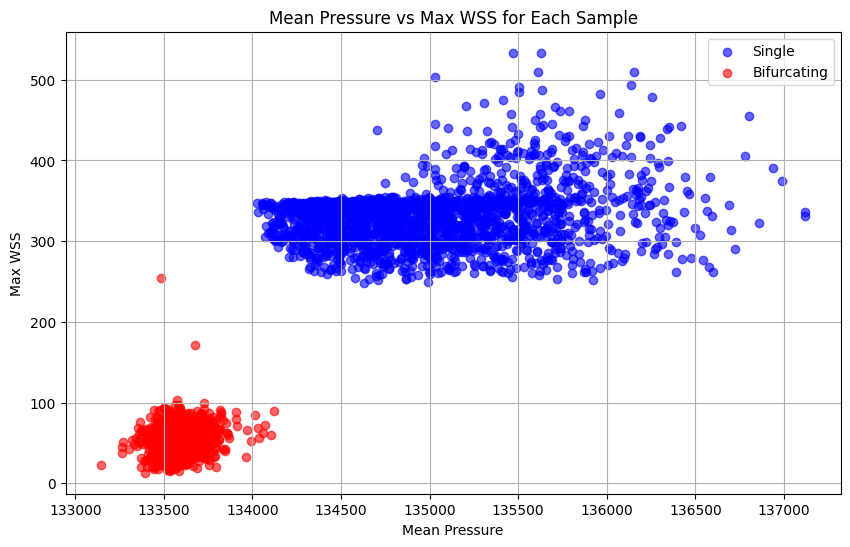

In [19]:
single_sample_stats = []
bifurcating_sample_stats = []
for sample in total_list:
  mean_pressure = None
  max_wss = None
  if sample[4] == 0:
    mean_pressure = np.mean(sample[2].numpy())
    max_wss = np.max(sample[0].numpy())
    single_sample_stats.append((mean_pressure, max_wss))
  else:
    mean_pressure = np.mean(sample[2].numpy())
    max_wss = np.max(sample[0].numpy())
    bifurcating_sample_stats.append((mean_pressure, max_wss))

single_np_array = np.array(single_sample_stats)
bifurcating_np_array = np.array(bifurcating_sample_stats)

plt.figure(figsize=(10, 6))

plt.scatter(single_np_array[:, 0], single_np_array[:, 1], color='blue', label='Single', alpha=0.6)
plt.scatter(bifurcating_np_array[:, 0], bifurcating_np_array[:, 1], color='red', label='Bifurcating', alpha=0.6)

plt.xlabel('Mean Pressure')
plt.ylabel('Max WSS')
plt.title('Mean Pressure vs Max WSS for Each Sample')
plt.legend()
plt.grid(True)

plt.show()

# Transformation in mv

In [20]:
def get_scalar_mv(tensor):
    """
    Embed the (n_items,) tensor vector in geometric algebra

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        (torch.Tensor): Embed of the scalar vector in geometric algebra
    """
    n_items = tensor.shape[0]
    reshaped_tensor = tensor.reshape(1,n_items,1,1)

    mv_shape = reshaped_tensor.shape[:3]
    mv = torch.zeros(*mv_shape, 16)

    # GATr was found to be more sensitive to widely
    # different values among the data. In terms of range
    # of values, the pressure exceeded the others by several
    # units of magnitude, so it was scaled to its submultiples
    mv[..., 0] = reshaped_tensor[...,0] * 1e-6

    return mv

In [22]:
pre_mv_tensor = torch.zeros(len(total_list),3)
for i,sample in enumerate(total_list):
  max_wss = torch.max(sample[0])
  mean_pressure = torch.mean(sample[2])
  pre_mv_tensor[i][0] = max_wss
  pre_mv_tensor[i][1] = mean_pressure
  pre_mv_tensor[i][2] = sample[4]

In [25]:
pre_mv_tensor.shape

torch.Size([3998, 3])